# HW4 Jonathan Cohen - 203372032

In [1]:
import numpy as np
import pystan
import arviz
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections.abc import Iterable
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from tqdm import tqdm
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=15)
N_SIM = 100

%matplotlib inline

In [2]:
iris = datasets.load_iris()
n, d = iris.data.shape
X = iris.data
k = 3
labels = iris.target

## The data

4 3d plots, each one with one feature removed (for viewing)

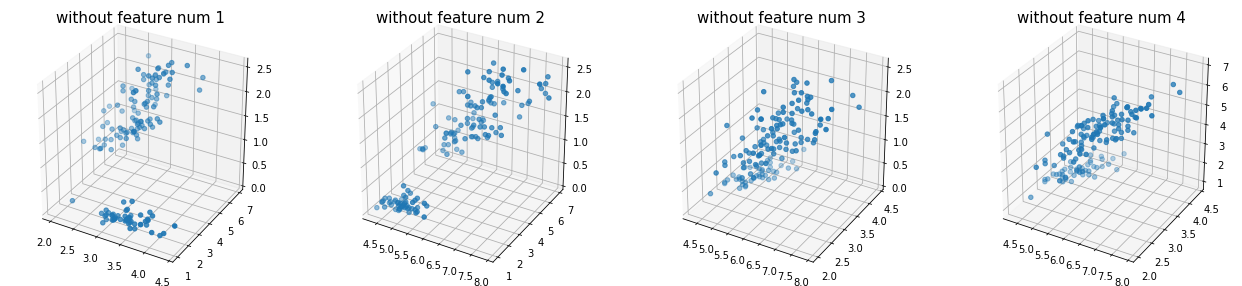

In [3]:
def subplot3d(X, no_ax):
  mask = np.ones(X.shape,dtype=bool)
  mask[:,no_ax] = 0
  xyz = np.reshape(X[mask], (n,k))
  x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
  return x, y, z

def plot3d(X):
  fig = plt.figure(figsize=(22, 5))
  for i in range(4):
    ax = fig.add_subplot(1, 4, 1+i, projection='3d')
    ax.set_title('without feature num {}'.format(i+1))
    x, y, z = subplot3d(X, i)
    ax.scatter(x,y,z)

plot3d(X)

From an initial visual analysis, it seams like features 3 and 4 are important for identification. This may depend on our view angle.

## Plots of the first PCA component of the 4d data (4d -> 1d)

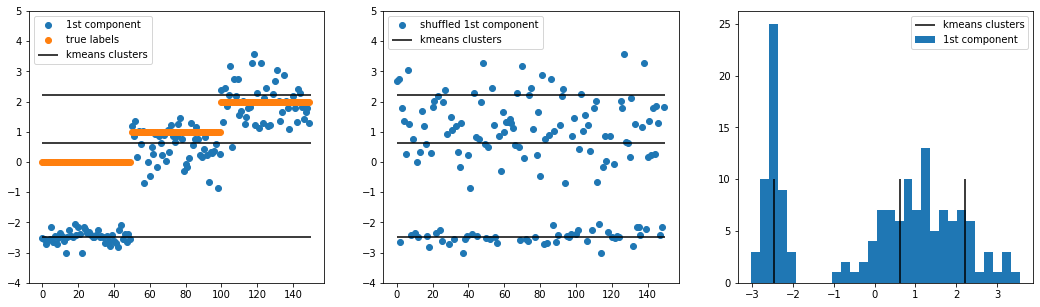

In [6]:
def norm(X, d):
  center_mass = np.array([np.mean(X[:,i]) for i in range(d)])
  X_centered = X - center_mass
  X_norm = X_centered/np.sqrt(np.var(X_centered))
  return X_norm

X_norm = norm(X, d)

def get_1st_pca_eigvec_comp(X, d):
  pca = PCA(1)
  pca.fit_transform(X_norm)
  eigenvector_1 = pca.components_[0]
  component_1 = pca.transform(X_norm)[:,0]
  return eigenvector_1, component_1


def get_kmeans_clusters(_component_1):
  component_11 = np.ones((_component_1.shape[0],2), dtype=np.float32)
  component_11[:,0] = _component_1
  kmeans = KMeans(n_clusters=k, random_state=0).fit(component_11)
  clusters = sorted(kmeans.cluster_centers_[:,0])
  return clusters



eigenvector_1, component_1 = get_1st_pca_eigvec_comp(X, d)
clusters = get_kmeans_clusters(component_1)
fig, ax = plt.subplots(1,3, figsize=(18, 5))
ax[0].scatter(range(n),component_1)
ax[0].scatter(range(n),labels)
ax[0].hlines(clusters, 0, n)
ax[0].legend(['1st component', 'true labels', 'kmeans clusters'])
ax[0].set_ylim(-4, 5)

comp_1_shuf = component_1.copy()
np.random.shuffle(comp_1_shuf)
ax[1].scatter(range(n),comp_1_shuf)
ax[1].hlines(clusters, 0, n)
ax[1].legend(['shuffled 1st component', 'kmeans clusters'], loc='upper left')
ax[1].set_ylim(-4, 5)

ax[2].hist(comp_1_shuf, bins=30)
ax[2].vlines(clusters, 0, 10)
ax[2].legend(['kmeans clusters', '1st component'])

# Initial data overview

We can see that the pca decomposition seperates the '0' labels nicely.

However, the '1' and '2' labels look mixed together, and the clusters are not very clear. It looks like they are taken from 1 gaussian and not two seperate ones.

We have the k-means clustering result for comparison during our analysis:

Because k-means uses l2 norm distancing, it is comparable with gaussian mixture models (this is only true for the 1d case, as in ours).

In [36]:

def get_posterior_samples(fit):
  fit_ss = fit.extract(permuted=False, inc_warmup=False)
  betas = fit_ss[:, 0,0:4]
  thetas = fit_ss[:, 0,4:7]
  mus = fit_ss[:, 0,7:10]
  sigmas = fit_ss[:, 0,10:13]
  return betas, thetas, mus, sigmas

def print_feature_informativeness(betas):
  print('feature num     mean     median')
  for i in range(d):
    feature_weights = betas[:,i]
    print('     {}          {:.2f}     {:.2f}'.format(
        i+1, abs(np.mean(feature_weights)), abs(np.median(feature_weights))))

betas, _, _, _ = get_posterior_samples(fit_lr_gmm)
print_feature_informativeness(betas)


feature num     mean     median
     1          0.32     0.31
     2          0.11     0.11
     3          0.81     0.81
     4          0.34     0.34


We can see that the 3rd feature contributes the most, the 2nd one contributes the least, to the linear combination (in absolute value). The 1st and 4th have similar contributions. If we had to choose just one feature to seperate with, it would be featue 3.

In [11]:
def importance_sample(probs):
    partition_of_01 = np.cumsum(probs)
    partition_of_01 += (1 - np.amax(partition_of_01))  # to ensure last element is exactly 1
    r = np.random.random()
    return np.digitize(r, partition_of_01)

def simulate_1d_gmm(thetas, mus, sigmas):
  data_1d_gmm = np.zeros((n,), dtype=np.float32)
  for i in range(n):
      ind = np.random.randint(0, n, 3)
      rand_theta = thetas[ind[0], :]
      rand_mu = mus[ind[1], :]
      rand_sigma = sigmas[ind[2], :]
      gaussian_ind = importance_sample(rand_theta)
      mu = rand_mu[gaussian_ind]
      sigma = rand_sigma[gaussian_ind]
      sample = np.random.normal(mu, sigma, 1)
      data_1d_gmm[i] = sample
  return data_1d_gmm

def simulate_1d_lr(betas):
  data_1d_lr = np.zeros((n,), dtype=np.float32)
  for i in range(n):
      ind = np.random.randint(0, n, 1)
      rand_beta = betas[ind, :]
      data_1d_lr[i] = np.dot(rand_beta, X_norm[i])    

  np.random.shuffle(data_1d_lr)
  return data_1d_lr


In [12]:

def plot_gmm_rl_pca_data(betas, thetas, mus, sigmas):
  data_1d_gmm = simulate_1d_gmm(thetas, mus, sigmas)
  data_1d_lr = simulate_1d_lr(betas)

  fig, ax = plt.subplots(3,2, figsize=(16, 8))
  # real
  ax[0,0].scatter(range(n),comp_1_shuf)
  ax[0,0].hlines(clusters, 0, n)
  ax[0,0].set_ylabel('real')
  ax[0,0].set_ylim(-3, 4)

  ax[0,1].hist(comp_1_shuf, bins=30)
  ax[0,1].vlines(clusters, 0, 10)
  ax[0,1].set_ylabel('real')
  ax[0,1].set_xlim(-4, 4)

  # lr
  ax[1,0].scatter(range(n),data_1d_lr)
  # ax[1,0].hlines(clusters, 0, n)
  ax[1,0].set_ylabel('rl simulated')
  ax[1,0].set_ylim(-3, 4)

  ax[1,1].hist(data_1d_lr, bins=30)
  # ax[1,1].vlines(clusters, 0, 10)
  ax[1,1].set_ylabel('rl simulated')
  ax[1,1].set_xlim(-4, 4)
  fig.legend(['', 'k means cluster centers'])


  # gmm
  ax[2,0].scatter(range(n),data_1d_gmm)
  # ax[2,0].hlines(clusters, 0, n)
  ax[2,0].set_ylabel('gmm simulated')
  ax[2,0].set_ylim(-3, 4)

  ax[2,1].hist(data_1d_gmm, bins=30)
  # ax[2,1].vlines(clusters, 0, 10)
  ax[2,1].set_ylabel('gmm simulated')
  ax[2,1].set_xlim(-4, 4)


In [14]:
def get_min_max_med_mean_var(a):
  return np.min(a), np.max(a), np.median(a), np.mean(a), np.var(a)

def plot_p_values_simulations(thetas, mus, sigmas, betas):
  gmms = [[],[],[],[],[],]
  lrs = [[],[],[],[],[]]
  e_gmms = [0,0,0,0,0]
  e_lrs = [0,0,0,0,0]

  for sim_num in range(N_SIM):
    data_1d_gmm = simulate_1d_gmm(thetas, mus, sigmas)
    data_1d_lr = simulate_1d_lr(betas)
    gmm_test_vars = get_min_max_med_mean_var(data_1d_gmm)
    lr_test_vars = get_min_max_med_mean_var(data_1d_lr)

    for i, (gmm_test_var, lr_test_var) in enumerate(zip(gmm_test_vars, lr_test_vars)):
      gmms[i].append(gmm_test_var)
      lrs[i].append(lr_test_var)
      e_gmms[i] += gmm_test_var
      e_lrs[i] += lr_test_var

  for i in range(len(e_lrs)):
    e_gmms[i] /= N_SIM
    e_lrs[i] /= N_SIM

  test_var_names = ['min', 'max','median', 'mean', 'variance']

  fig, ax = plt.subplots(2,5, figsize=(18, 6))

  ax[0,0].set_ylabel('gmm simulations')
  for i in range(5):
    ax[0,i].hist(gmms[i])
    ax[0,i].axvline(e_lrs[i], color="red")
    ax[0,i].set_title("p-value {}".format(len([x for x in gmms[i] if x < e_lrs[i]])/N_SIM))
    ax[0,i].set_xlabel(test_var_names[i])

  ax[1,0].set_ylabel('lr simulations')
  for i in range(5):
    ax[1,i].hist(lrs[i])
    ax[1,i].axvline(e_gmms[i], color="red")
    ax[1,i].set_title("p-value {}".format(len([x for x in lrs[i] if x < e_gmms[i]])/N_SIM))
    ax[1,i].set_xlabel(test_var_names[i])


  fig.tight_layout()


# A second model
Lets try a weaker prior on beta, giving the linear regression more freedom to move away from the PCA 1st component, and fit the gaussian mixture better 

In [16]:
model_beta_prior_sigma = """
data {
  int<lower=0> N; // num points
  int<lower=0> D;
  int<lower=0> K; // num clusters
  matrix[N, D] x;
  vector[D] beta_prior;
  real<lower=0> beta_prior_sigma;                    // <-- difference here
}

parameters {
  vector[D] beta;

  simplex[K] theta;
  ordered[K] mu;
  vector<lower=0>[K] sigma;
}

model {
  sigma ~ lognormal(0, 1);
  mu ~ normal(0,10);
  theta ~ normal(0.33, 0.12);
  beta ~ normal(beta_prior, beta_prior_sigma);       // <-- difference here

  for (n in 1:N) {
    vector[K] lps = log(theta);
    for (k in 1:K)
      lps[k] += normal_lpdf( (x[n] * beta) | mu[k], sigma[k]);
    target += log_sum_exp(lps);
  }
}
"""
compiled_model_beta_prior_sigma = pystan.StanModel(model_code=model_beta_prior_sigma)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8300c96135a8c77e5cb88a3a72a1bdfe NOW.


In [31]:
data_beta_prior_sigma = {
    'N': n,
    'D': d,
    'K': k,
    'x': X_norm,
    'beta_prior': eigenvector_1,
    'beta_prior_sigma': 0.037      # weakest prior that still converges
}
fit_beta_prior_sigma = compiled_model_beta_prior_sigma.sampling(data=data_beta_prior_sigma, iter=1000, chains=4)

k-means clusters: [-2.4796195, 0.6190654, 2.2107172]
beta prior: [ 0.36138659 -0.08452251  0.85667061  0.3582892 ]

Inference for Stan model: anon_model_8300c96135a8c77e5cb88a3a72a1bdfe.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]    0.18  1.0e-3   0.04   0.11   0.15   0.17    0.2   0.25   1168    1.0
beta[2]   -0.14  7.2e-4   0.03   -0.2  -0.16  -0.14  -0.12  -0.08   1790    1.0
beta[3]    0.62  1.7e-3   0.04   0.53   0.59   0.62   0.65   0.71    669    1.0
beta[4]    0.26  9.9e-4   0.04   0.19   0.24   0.26   0.29   0.33   1441    1.0
theta[1]   0.34  8.0e-4   0.04   0.27   0.31   0.34   0.36   0.41   1947    1.0
theta[2]   0.34  2.8e-3   0.09   0.16   0.27   0.34    0.4   0.52   1087    1.0
theta[3]   0.33  2.8e-3   0.09   0.15   0.27   0.33   0.39    0.5   1031    1.0
mu[1]     -1.75  5.0e-3   0.12  -1.99  -1.84  -1.76  -1.6

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdc1b1ee710>,
      dtype=object)

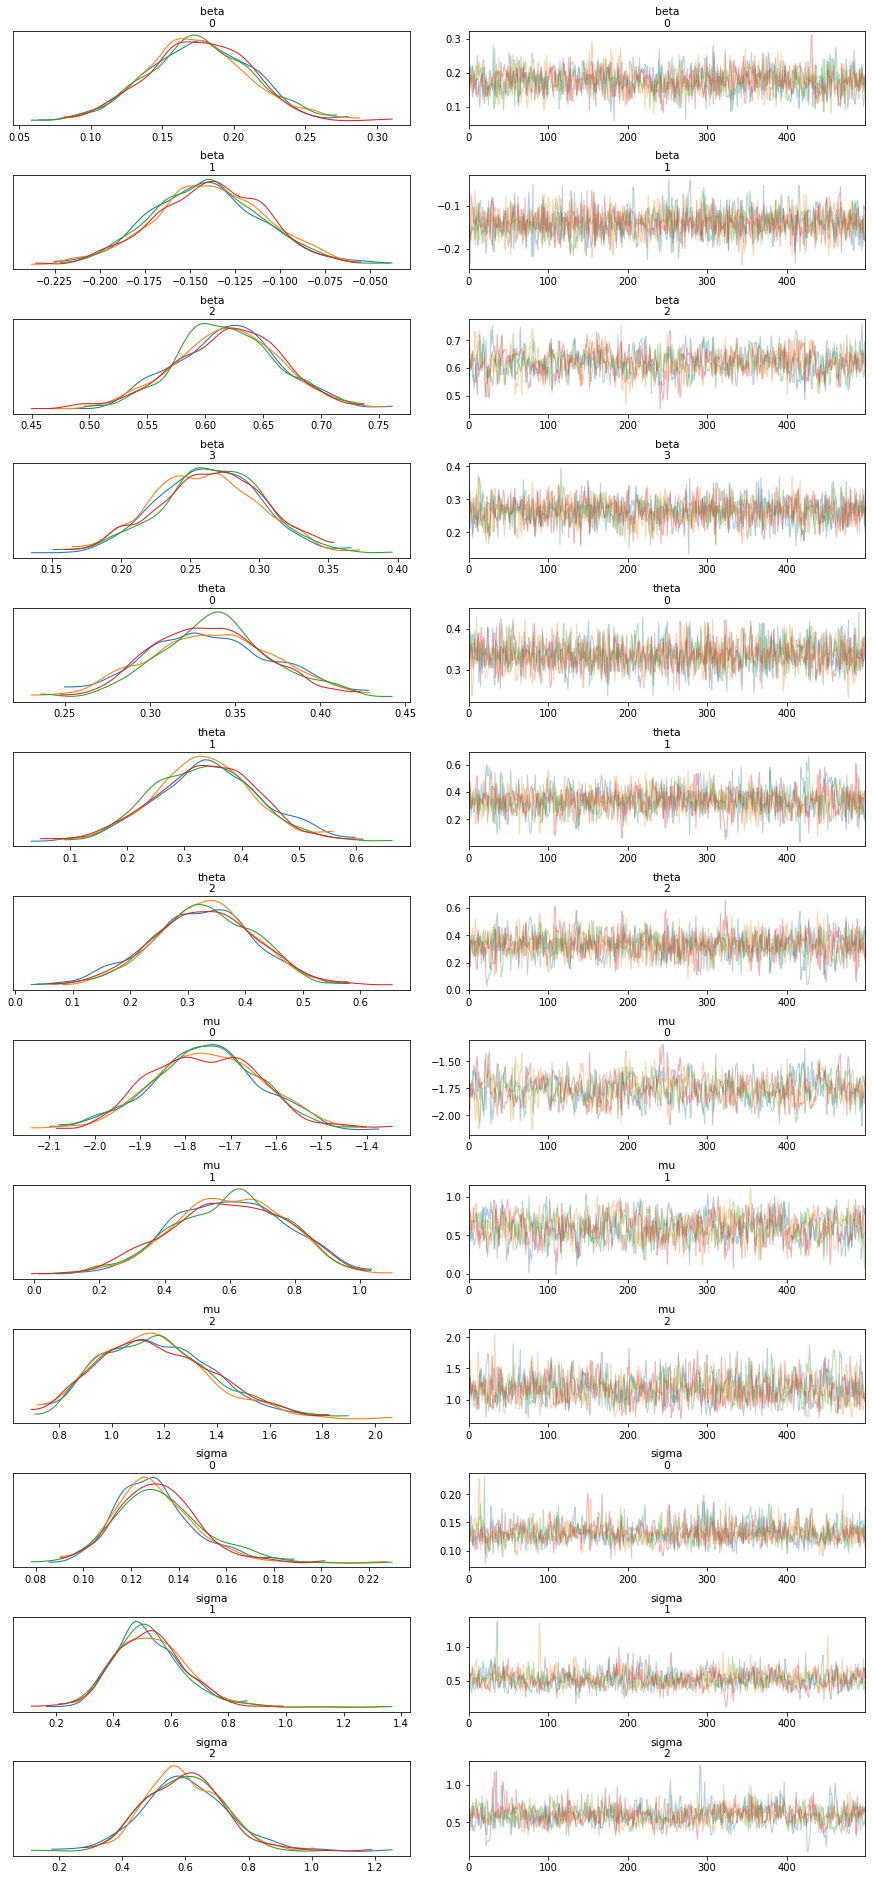

In [32]:
print("k-means clusters: {}".format(clusters))
print("beta prior: {}".format(eigenvector_1))
print()
print(fit_beta_prior_sigma)
arviz.plot_trace(fit_beta_prior_sigma)

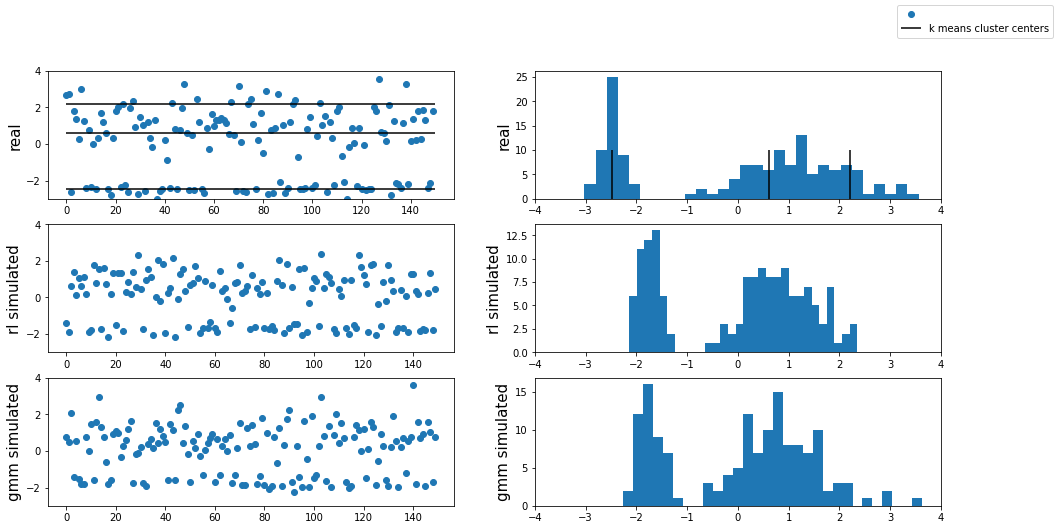

In [19]:
betas2, thetas2, mus2, sigmas2 = get_posterior_samples(fit_beta_prior_sigma)
plot_gmm_rl_pca_data(betas2, thetas2, mus2, sigmas2)

## The difference
We can see that the simulated data is different then the 'real' (1st PCA component) data. Let's see If the new linear regression data fits the expected test variables of the gmm simulation (and the other way around)

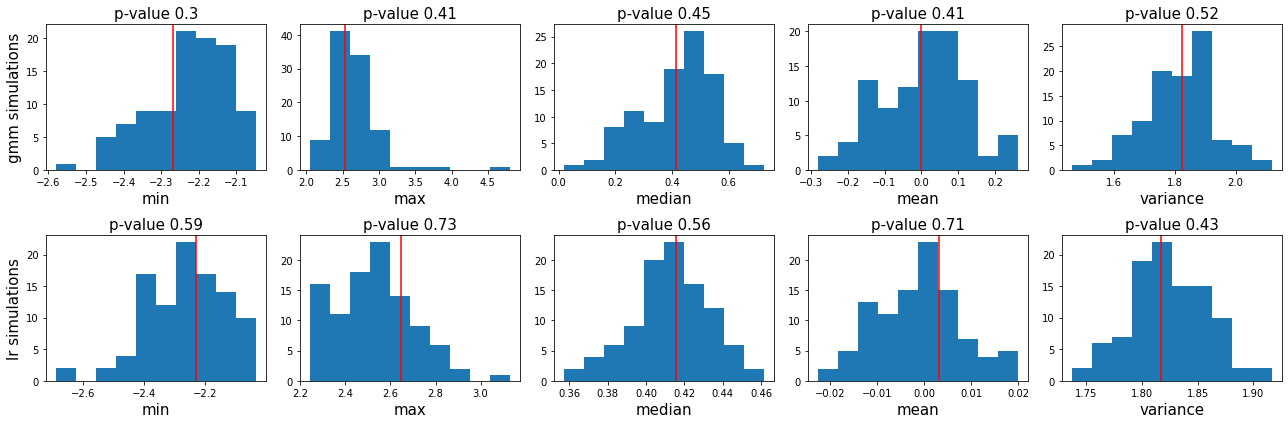

In [20]:
plot_p_values_simulations(thetas2, mus2, sigmas2, betas2)

# Informativeness of the new features

In [39]:
print_feature_informativeness(betas2)

previous model:
feature num     mean     median
     1          0.32     0.31
     2          0.11     0.11
     3          0.81     0.81
     4          0.34     0.34

new model
feature num     mean     median
     1          0.18     0.18
     2          0.14     0.14
     3          0.62     0.62
     4          0.27     0.27


Our new analysis shows that the 3rd feature is still the most significant in seperating the species.

However, the 4th feature has a higher weight (in absolut value) then the 1st one.

This consides with out initial visual analysis (top of this document), which encourages us that the second model is indeed better than the 1st one.

# A Clustering function
We will use our knowledge to cluster the data, and see if it matched the true labels.

for each data point, we will simulate betas, mus, and sigmas. Then we will classify to the gaussian with the total highest probability.
* this will be the first time we use the labels in this analysis

In [68]:
def _get_gaussian_densities(point, mus, sigmas, betas):
  ind = np.random.randint(0, n, 3)
  rand_beta = betas[ind[0], :]
  rand_mu = mus[ind[1], :]
  rand_sigma = sigmas[ind[2], :]

  point1d = np.dot(rand_beta, point)
  ps = np.zeros(k, dtype=np.float32)
  for i in range(k):
    ps[i] = stats.norm.pdf(point1d, rand_mu[i], rand_sigma[i])
  return ps


def classify(point, mus, sigmas, betas):
  ps_total = np.zeros(k, dtype=np.float32)
  for i in range(N_SIM):
    ps_total += _get_gaussian_densities(point, mus, sigmas, betas)
  return np.argmax(ps_total)
  

def get_cluster_accuracy(mus, sigmas, betas):
  correct = 0  
  for i in range(n):
    pred = classify(X_norm[i], mus, sigmas, betas)
    if pred == labels[i]:
      correct += 1
  return correct/n

print('first model clustering accuracy: {:.2f}'.format(get_cluster_accuracy(mus, sigmas, betas)))
print('second model clustering accuracy: {:.2f}'.format(get_cluster_accuracy(mus2, sigmas2, betas2)))


first model clustering accuracy: 0.92
second model clustering accuracy: 0.95


## The improved model predicts with better accuracy

# Model evaluation


In [76]:
fit_cache = [0 for i in range(n)]

In [148]:
fit_cache_old_model = [0 for i in range(n)]

In [161]:
def get_lppd_full(data_points, betas, thetas, mus, sigmas):
  total_sum = 0
  for data_point in data_points:
    total_sum += get_lppd_single(data_point, betas, thetas, mus, sigmas)

  return total_sum

def get_lppd_single(data_point, betas, thetas, mus, sigmas):
  p_sum = 0
  for i in range(n):
    beta = betas[i, :]
    mu = mus[i, :]
    sigma = sigmas[i, :]
    theta = thetas[i, :]
    point1d = np.dot(beta, data_point)
    for i in range(k):
      p = stats.norm.pdf(point1d, mu[i], sigma[i]) * theta[i]
      p_sum += p

  return np.log(p_sum / n)


def get_loocv_lppd_single(loo_index, beta_prior_sigma, is_old_model):
  mask = np.ones(X_norm.shape, dtype=bool)
  mask[loo_index,:] = 0
  X_norm_loo = np.reshape(X_norm[mask], (n-1, d))
  loo_data_point = X_norm[loo_index]
  data_loo = {
    'N': n-1,
    'D': d,
    'K': k,
    'x': X_norm_loo,
    'beta_prior': eigenvector_1,
    'beta_prior_sigma': beta_prior_sigma
  }
  cache = fit_cache_old_model if is_old_model else fit_cache
  if cache[loo_index] == 0:
    fit_loo = compiled_model_beta_prior_sigma.sampling(data=data_loo, iter=1000, chains=4)
    cache[loo_index] = fit_loo
  else:
    fit_loo = cache[loo_index]
  
  betas_loo, thetas_loo, mus_loo, sigmas_loo = get_posterior_samples(fit_loo)
  return get_lppd_single(loo_data_point, betas_loo, thetas_loo, mus_loo, sigmas_loo)


def get_loocv_lppd_full(beta_prior_sigma, is_old_model):
  total_sum = 0
  for i in range(n):
    lppd_loo = get_loocv_lppd_single(i, beta_prior_sigma, is_old_model)
    total_sum += lppd_loo
  return total_sum

In [163]:
lppd_full = get_lppd_full(X_norm, betas2, thetas2, mus2, sigmas2)
loocv_lppd_full = get_loocv_lppd_full(0.037, is_old_model=False)
lppd_full_old_model = get_lppd_full(X_norm, betas, thetas, mus, sigmas)
loocv_lppd_full_old_model = get_loocv_lppd_full(0.02, is_old_model=True)
print('                1st model              improved model')
print('-2lppd       :     {:.2f}                         {:.2f}'.format(-2*lppd_full_old_model, -2*lppd_full))
print('p loo-cv     :     {:.2f}                         {:.2f}'.format(lppd_full_old_model-loocv_lppd_full_old_model, lppd_full-loocv_lppd_full))
print('-2lppd loo-cv:     {:.2f}                         {:.2f}'.format(-2*loocv_lppd_full_old_model, -2*loocv_lppd_full))


                1st model              improved model
-2lppd       :     422.55                         312.59
p loo-cv     :     8.15                         14.86
-2lppd loo-cv:     438.85                         342.31


In [ ]:
|